In [2]:
%load_ext autoreload
%autoreload 2

# 1. Các thư viện cần thiết

In [23]:
import os
import cv2
import numpy as np
from tqdm.notebook import tqdm
from pathlib import Path
from matplotlib import pyplot as plt
from model import ThresholdbasedSegmentation
from model import EdgebasedSegmentation

# 2. Phương pháp phân ngưỡng

In [4]:
train_set = {
    'images': './dataset/images/train/',
    'labels': './dataset/labels/train/'
}

model_threshold = ThresholdbasedSegmentation()
model_threshold.fit(train_set)

# model_edge = EdgebasedSegmentation()
# model_edge.fit(train_set)

In [10]:
# image_path = 'dataset/images/test/1xemay509.jpg'
# image = cv2.imread(image_path)
# (h, w) = image.shape[:2]

# bboxes = model_threshold.predict(image)
# for c_x, c_y, box_w, box_h in bboxes:    
#     x1 = int((c_x - box_w / 2) * w)
#     y1 = int((c_y - box_h / 2) * h)
    
#     x2 = int((c_x + box_w / 2) * w)
#     y2 = int((c_y + box_h / 2) * h)
    
#     image = cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

# plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
# plt.show()

# 3. Phương pháp dựa trên cạnh

In [6]:
train_set = {
    'images': './dataset/images/train/',
    'labels': './dataset/labels/train/'
}

model_edge = EdgebasedSegmentation()
model_edge.fit(train_set)

In [9]:
# image_path = 'dataset/images/test/1xemay509.jpg'
# image = cv2.imread(image_path)
# (h, w) = image.shape[:2]

# mask = np.zeros(image.shape[:2])

# bboxes = model_edge.predict(image)
# for c_x, c_y, box_w, box_h in bboxes:    
#     x1 = int((c_x - box_w / 2) * w)
#     y1 = int((c_y - box_h / 2) * h)
    
#     x2 = int((c_x + box_w / 2) * w)
#     y2 = int((c_y + box_h / 2) * h)
    
#     image = cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
#     mask[y1:y2+1, x1:x2+1] = 255

# plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
# plt.axis('off')
# plt.show()

# plt.imshow(mask, 'gray')
# plt.axis('off')
# plt.show()

# 4. Đánh giá phương pháp

In [13]:
def iou(pred, actual):
    assert pred.shape == actual.shape
    intersect = np.sum(np.logical_and(pred, actual))
    union = np.sum(np.logical_or(pred, actual))
    return intersect / union

def bboxes_to_mask(image, bboxes):
    (h, w) = image.shape[:2]
    mask = np.zeros(image.shape[:2])
    
    for c_x, c_y, box_w, box_h in bboxes:
        x1 = int((c_x - box_w / 2) * w)
        y1 = int((c_y - box_h / 2) * h)
        x2 = int((c_x + box_w / 2) * w)
        y2 = int((c_y + box_h / 2) * h)
        
        mask[y1:y2+1, x1:x2+1] = 1
        
    return mask

In [26]:
test_set = {
    'images': './dataset/images/test/',
    'labels': './dataset/labels/test/'
}

cnt = 0
mean_iou = np.array([0.0, 0.0])

images_file = os.listdir(test_set['images'])
for image_file in tqdm(images_file):
    image = cv2.imread(os.path.join(test_set['images'], image_file))
    
    label = open(os.path.join(test_set['labels'], Path(image_file).stem + '.txt'), 'r')
    bboxes = [list(map(float, line.split()))[1:] for line in label.readlines()]
    
    predict_bboxes_1 = model_threshold.predict(image.copy())
    predict_bboxes_2 = model_edge.predict(image.copy())
    
    ground_truth = bboxes_to_mask(image, bboxes)
    mask_1 = bboxes_to_mask(image, predict_bboxes_1)
    mask_2 = bboxes_to_mask(image, predict_bboxes_2)
    
    cnt += 1
    mean_iou[0] += iou(mask_1, ground_truth) 
    mean_iou[1] += iou(mask_2, ground_truth) 
    
mean_iou /= float(cnt)

  0%|          | 0/540 [00:00<?, ?it/s]

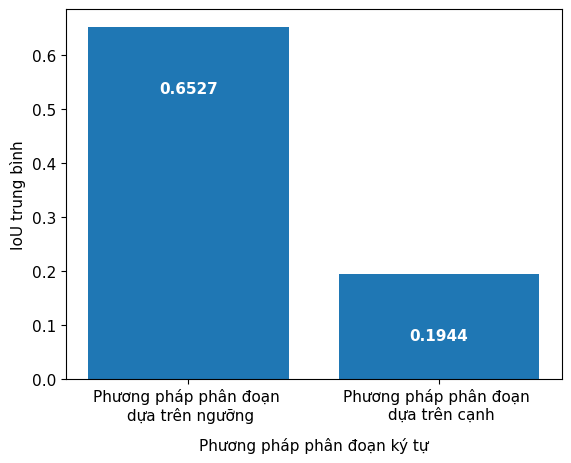

In [68]:
plt.rcParams.update({'font.size': 11})

labels = ['Phương pháp phân đoạn \n dựa trên ngưỡng', 'Phương pháp phân đoạn \n dựa trên cạnh']

plt.xlabel('Phương pháp phân đoạn ký tự', labelpad=10)
plt.ylabel('IoU trung bình')
bar_container = plt.bar(labels, mean_iou)
plt.bar_label(bar_container, mean_iou.round(4), padding=-50, color='w', weight='bold')
plt.show()

# 5. Một số kết quả thực tế

  0%|          | 0/6 [00:00<?, ?it/s]

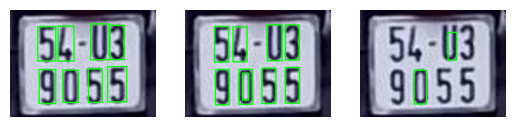

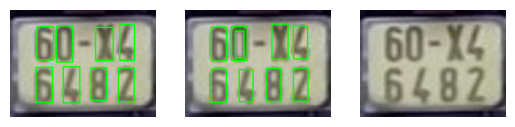

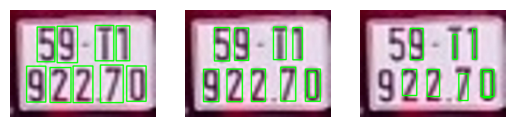

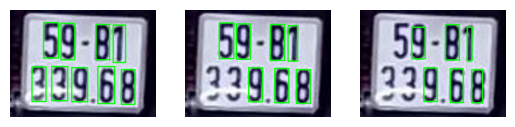

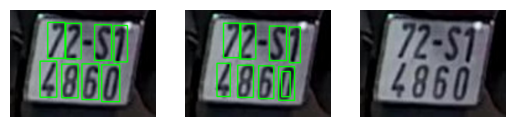

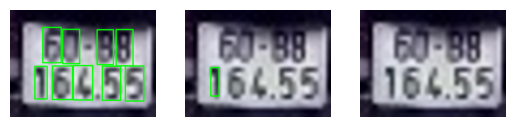

In [65]:
images_file = [
    'dataset/images/test/1xemay1043.jpg',
    'dataset/images/test/1xemay1907.jpg',
    'dataset/images/test/2xemay1871.jpg',
    'dataset/images/test/2xemay479.jpg',
    'dataset/images/test/11CarLongPlate84.jpg',
    'dataset/images/test/2xemay1895.jpg'
]

cnt = 0
for image_file in tqdm(images_file):
    image = cv2.imread(image_file)
    (h, w) = image.shape[:2]
    
    label = open(os.path.join('dataset/labels/test/', Path(image_file).stem + '.txt'), 'r')
    bboxes = [list(map(float, line.split())) for line in label.readlines()]
    
    image_0 = image.copy()
    for bbox in bboxes:
        (h, w) = image.shape[:2]
        
        x1 = int((bbox[1] - bbox[3] / 2) * w)
        y1 = int((bbox[2] - bbox[4] / 2) * h)
        
        x2 = int((bbox[1] + bbox[3] / 2) * w)
        y2 = int((bbox[2] + bbox[4] / 2) * h)
        
        image_0 = cv2.rectangle(image_0, (x1, y1), (x2, y2), (0, 255, 0), 5)
    
    predict_bboxes_1 = model_threshold.predict(image.copy())
    predict_bboxes_2 = model_edge.predict(image.copy())
    
    image_1 = image.copy()
    for c_x, c_y, box_w, box_h in predict_bboxes_1:    
        x1 = int((c_x - box_w / 2) * w)
        y1 = int((c_y - box_h / 2) * h)
        
        x2 = int((c_x + box_w / 2) * w)
        y2 = int((c_y + box_h / 2) * h)
        
        image_1 = cv2.rectangle(image_1, (x1, y1), (x2, y2), (0, 255, 0), 5)
    
    image_2 = image.copy()
    for c_x, c_y, box_w, box_h in predict_bboxes_2:
        x1 = int((c_x - box_w / 2) * w)
        y1 = int((c_y - box_h / 2) * h)
        
        x2 = int((c_x + box_w / 2) * w)
        y2 = int((c_y + box_h / 2) * h)
        
        image_2 = cv2.rectangle(image_2, (x1, y1), (x2, y2), (0, 255, 0), 5)
    
    cnt += 1
    
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(image_0, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    # plt.savefig('image_%d_1' % (cnt))
    # plt.show()
    
    plt.subplot(1, 3, 2)
    plt.imshow(cv2.cvtColor(image_1, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    # plt.savefig('image_%d_2' % (cnt))
    # plt.show()
    
    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(image_2, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()